In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertForMaskedLM, BertConfig, AdamW
from transformers import DataCollatorForLanguageModeling
from tokenizers import BertWordPieceTokenizer
from datasets import load_dataset
import os
from datetime import datetime
import os
import matplotlib.pyplot as plt
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

/anaconda/envs/llm-rag-embeddings/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


기존 데이터

In [4]:
# # 경로 설정 : 데이터를 읽어오는 곳
    
# path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/CODE/사출성형/tokenizer_data/"

# all_texts = []

# # 폴더 내의 모든 txt 파일의 데이터를 모음
# for file in os.listdir(path):
#     if file.endswith('.txt'):
#         file_path = os.path.join(path, file)
#         with open(file_path, 'r', encoding='utf-8') as f:
#             all_texts.append(f.read())

# file_paths = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.txt')] #list


# # 데이터셋 로드
# dataset = load_dataset('text', data_files=file_paths, cache_dir='/home/azureuser/cloudfiles/code/Users/hb.suh/cache')

# from datasets import DatasetDict, Dataset

# # 훈련 데이터셋을 훈련 세트와 검증 세트로 분할
# train_test_split = dataset['train'].train_test_split(test_size=0.2)

# # 분할된 데이터셋을 다시 DatasetDict로 구성
# dataset = DatasetDict({
#     'train': train_test_split['train'],
#     'valid': train_test_split['test']
# })

# print(dataset)

새로 수집한 데이터

In [2]:
import os
import json
from datasets import Dataset, DatasetDict, load_dataset

# 여러 경로를 리스트에 저장
text_paths = [
    
    "/home/azureuser/cloudfiles/code/Users/hb.suh/(0522part)_번역원본",
    "/home/azureuser/cloudfiles/code/Users/hb.suh/(0527part)_번역원본",
    "/home/azureuser/cloudfiles/code/Users/hb.suh/(0522part)_OnlyTranslatedData/사출성형",
    "/home/azureuser/cloudfiles/code/Users/hb.suh/(0527part)_OnlyTranslatedData"
]

before_paths = ["/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/CODE/사출성형/tokenizer_data/"]

json_paths = [
    "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/CODE/TestGPT_data/"
]


main_content_texts = []
for onepath in text_paths:
    for file in os.listdir(onepath):
        if file.endswith('.txt'):
            with open(os.path.join(onepath, file), 'r', encoding='utf-8') as f:
                lines = f.readlines()
                main_content = ""
                extract = False

                for line in lines:
                    # "main_content:" 또는 "Main Content:"로 시작
                    if line.strip().lower().startswith("main_content:") or line.strip().lower().startswith("main content:"):
                        if extract and main_content:
                            # 이전에 추출된 main_content를 추가합니다.
                            main_content_texts.append(main_content.strip())
                            main_content = ""
                        extract = True
                        # "main_content:" 이후의 내용을 추출합니다.
                        main_content = line.strip().split(":", 1)[1].strip()
                    elif extract:
                        if line.strip() == "":
                            # 빈 줄이 나오면 추출을 중지하고 main_content를 추가합니다.
                            main_content_texts.append(main_content.strip())
                            extract = False
                            main_content = ""
                        else:
                            # 이어지는 줄을 main_content에 추가합니다.
                            main_content += " " + line.strip()

                # 파일 끝에 도달했을 때 남아있는 main_content를 추가합니다.
                if main_content:
                    main_content_texts.append(main_content.strip())

main_content_texts[2]

'ABSTRACT Printed electrolyte-gated transistors (EGTs) are an emerging biosensor platform that leverage the facile fabrication engendered by printed electronics with the low voltage operation enabled by ion gel dielectrics. The resulting label-free, nonoptical sensors have high gain and provide sensing operations that can be challenging for conventional chemical field effect transistor architectures. After providing an overview of EGT device fabrication and operation, we highlight opportunities for microfluidic enhancement of EGT sensor performance via multiplexing, sample preconcentration, and improved transport to the sensor surface. Published under license by AIP Publishing. https://doi.org/10.1063/1.5131365 1. INTRODUCTION Surface-based adsorption, where an analyte of interest is pulled down from a solution by a specific capture agent, such as an antibody, is a standard biosensing method. These surface adsorption-based assays typically rely on an optical readout, such as the fluore

In [ ]:
# GPU 활동
!nvidia-smi

In [3]:
# 기존 txt 파일 경로를 모두 합침
file_paths = []
for path in before_paths:
    file_paths.extend([os.path.join(path, file) for file in os.listdir(path) if file.endswith('.txt')])

# JSON 파일에서 ["contents"] 추출
json_contents = []
for namefolder in os.listdir(json_paths[0]):
    folder_path = os.path.join(json_paths[0], namefolder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.json'):
                json_path = os.path.join(folder_path, file)
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    json_contents.extend(data.get("contents", []))

# 기존 텍스트 파일 데이터셋 로드
text_dataset = load_dataset('text', data_files=file_paths, cache_dir='/home/azureuser/cloudfiles/code/Users/hb.suh/cache')

# JSON 파일에서 추출한 contents를 데이터셋으로 변환
json_dataset = Dataset.from_dict({"text": json_contents})

# text_path의 main_content 데이터를 데이터셋으로 변환
main_content_dataset = Dataset.from_dict({"text": main_content_texts})

# 텍스트와 JSON 데이터셋 병합
combined_dataset = DatasetDict({
    "text_files": text_dataset['train'],
    "json_contents": json_dataset,
    "main_contents": main_content_dataset
})

# 데이터셋 확인 (예시)
print(combined_dataset)


DatasetDict({
    text_files: Dataset({
        features: ['text'],
        num_rows: 944
    })
    json_contents: Dataset({
        features: ['text'],
        num_rows: 1193
    })
    main_contents: Dataset({
        features: ['text'],
        num_rows: 1484
    })
})


In [4]:
# 데이터셋 로드

from datasets import DatasetDict, Dataset

# 각 데이터셋을 train과 test로 분할
text_files_split = combined_dataset['text_files'].train_test_split(test_size=0.2)
json_contents_split = combined_dataset['json_contents'].train_test_split(test_size=0.2)
main_contents_split = combined_dataset['main_contents'].train_test_split(test_size=0.2)

# 분할된 데이터셋을 다시 DatasetDict로 구성
train_test_combined_dataset = DatasetDict({
    'train': DatasetDict({
        'text_files': text_files_split['train'],
        'json_contents': json_contents_split['train'],
        'main_contents': main_contents_split['train']
    }),
    'val': DatasetDict({
        'text_files': text_files_split['test'],
        'json_contents': json_contents_split['test'],
        'main_contents': main_contents_split['test']
    })
})

print(train_test_combined_dataset)


DatasetDict({
    train: DatasetDict({
        text_files: Dataset({
            features: ['text'],
            num_rows: 755
        })
        json_contents: Dataset({
            features: ['text'],
            num_rows: 954
        })
        main_contents: Dataset({
            features: ['text'],
            num_rows: 1187
        })
    })
    val: DatasetDict({
        text_files: Dataset({
            features: ['text'],
            num_rows: 189
        })
        json_contents: Dataset({
            features: ['text'],
            num_rows: 239
        })
        main_contents: Dataset({
            features: ['text'],
            num_rows: 297
        })
    })
})


In [5]:
# 텍스트 파일 경로를 파일로 저장

merged_file_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/merged_data.txt"
with open(merged_file_path, 'w', encoding='utf-8') as f:
    # text_files 데이터셋 저장
    for item in combined_dataset['text_files']:
        text = item['text']
        if isinstance(text, dict):
            text = json.dumps(text)
        f.write(text + '\n')
    
    # json_contents 데이터셋 저장
    for item in combined_dataset['json_contents']:
        text = item['text']
        if isinstance(text, dict):
            text = json.dumps(text)
        f.write(text + '\n')
    
    # main_contents 데이터셋 저장
    for item in combined_dataset['main_contents']:
        text = item['text']
        if isinstance(text, dict):
            text = json.dumps(text)
        f.write(text + '\n')

In [6]:
from tokenizers import BertWordPieceTokenizer

# BertWordPieceTokenizer 인스턴스 생성
tokenizer = BertWordPieceTokenizer(clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix="##")

# 훈련하기
tokenizer.train(
    merged_file_path,
    vocab_size=30000,
    min_frequency=3,
    show_progress=True,
    special_tokens = ["[PAD]", "[CLS]", "[UNK]", "[SEP]", "[MASK]"],
    wordpieces_prefix="##",
)

# 저장할 디렉토리 경로    
save_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0530_AddData_bertwordpiece"

# 디렉토리가 없으면 생성
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 토크나이저 모델 저장
tokenizer.save_model(save_path)

['/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0530_AddData_bertwordpiece/vocab.txt']

In [7]:
# 새로운 토크나이저 로드
new_tokenizer = BertTokenizerFast.from_pretrained('beomi/kcbert-base')
model = BertForMaskedLM.from_pretrained('beomi/kcbert-base')
len(new_tokenizer)

new_tokens_added = 0
new_vocab = {}  # 새로운 토큰과 아이디를 담을 딕셔너리

#path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0527test_bertwordpiece/vocab.txt"
path = os.path.join(save_path, "vocab.txt")
# 기존의 토크나이저 vocab에서 새로운 토큰들을 제외하고 아이디 부여
with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        token = line.strip()  # 줄바꿈 문자를 제거하여 토큰만 가져옴
        if token not in new_tokenizer.get_vocab():
            new_tokenizer.add_tokens(token)
            new_tokens_added += 1
            new_vocab[token] = len(new_tokenizer) - 1  # 새로운 토큰에 새로운 아이디 부여

        else:
            # 토큰이 이미 존재하면, 기존 ID 사용
            new_vocab[token] = new_tokenizer.convert_tokens_to_ids(token)

print("new_tokens_added : ", new_tokens_added)
print(len(new_tokenizer))

# 토크나이저 모델 파일 저장
tokenizer_model_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0530_AddData_bertwordpiece"
new_tokenizer.save_pretrained(tokenizer_model_path,do_lower_case=False)

len(new_tokenizer)

print(f"Added {new_tokens_added} new tokens")


Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


new_tokens_added :  939
30939
Added 939 new tokens


TEST

In [6]:
# 2. 데이터셋 토큰화

# def tokenize_data(tokenizer, dataset):
#     def tokenize_function(examples):
#         # tokenizer의 결과에서 'input_ids'와 'attention_mask'만 반환하도록 수정 #128
#         tokenized_output = tokenizer(examples['text'], max_length=300, truncation=True, padding="max_length", return_tensors="pt")
#         return {'input_ids': tokenized_output['input_ids'], 'attention_mask': tokenized_output['attention_mask']}
#     return dataset.map(tokenize_function, batched=True, remove_columns=['text'])
  

# def resize_and_initialize_embeddings(model, tokenizer, old_tokenizer=None):
#     # 모델의 원래 토큰 임베딩 크기
#     original_num_tokens = model.config.vocab_size if old_tokenizer is None else len(old_tokenizer)
    
#     # 새 토크나이저에 따른 임베딩 크기 조정
#     new_num_tokens = len(tokenizer)
#     model.resize_token_embeddings(new_num_tokens)

#     # 임베딩 레이어에 접근
#     embeddings = model.get_input_embeddings()
    
#     # 새로운 토큰이 추가되었을 경우
#     if new_num_tokens > original_num_tokens:
#         # 기존 임베딩의 평균과 표준편차 계산
#         with torch.no_grad():
#             old_embeddings = embeddings.weight[:original_num_tokens]
#             mean, std = old_embeddings.mean(dim=0), old_embeddings.std(dim=0)
#             # 새로운 토큰의 임베딩 초기화
#             new_embeddings = torch.randn(new_num_tokens - original_num_tokens, embeddings.embedding_dim)
#             new_embeddings = mean + std * new_embeddings
#             embeddings.weight[original_num_tokens:] = new_embeddings

#     return model
new_tokenizer = BertTokenizerFast.from_pretrained('beomi/kcbert-base')
model = BertForMaskedLM.from_pretrained('beomi/kcbert-base')


# 기존 가중치 freeze
def resize_and_initialize_embeddings(model, tokenizer, old_tokenizer=None):
    # 모델의 원래 토큰 임베딩 크기
    original_num_tokens = model.config.vocab_size if old_tokenizer is None else len(old_tokenizer)
    
    # 새 토크나이저에 따른 임베딩 크기 조정
    new_num_tokens = len(tokenizer)
    model.resize_token_embeddings(new_num_tokens)

    # 임베딩 레이어에 접근
    embeddings = model.get_input_embeddings()
    
    # 기존 임베딩의 그라디언트 업데이트 비활성화
    embeddings.weight.requires_grad = False

    # 새로운 토큰이 추가되었을 경우
    if new_num_tokens > original_num_tokens:
        # 새로운 토큰의 임베딩만 그라디언트 업데이트 활성화
        embeddings.weight[original_num_tokens:].requires_grad = True
        
        # 기존 임베딩의 평균과 표준편차 계산
        with torch.no_grad():
            old_embeddings = embeddings.weight[:original_num_tokens]
            mean, std = old_embeddings.mean(dim=0), old_embeddings.std(dim=0)
            # 새로운 토큰의 임베딩 초기화
            new_embeddings = torch.randn(new_num_tokens - original_num_tokens, embeddings.embedding_dim, device=old_embeddings.device)
            new_embeddings = mean + std * new_embeddings
            embeddings.weight[original_num_tokens:].data = new_embeddings

    return model


# model = BertForMaskedLM.from_pretrained('beomi/kcbert-base')
# 드롭아웃 비율 조정
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Dropout):
        module.p = 0.3  # 드롭아웃 확률을 0.3으로 조정
###############################################################
after_add_Trained_Tokenizer = BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0530_AddData_bertwordpiece/",do_lower_case=False)

model = resize_and_initialize_embeddings(model, after_add_Trained_Tokenizer )
print(len(after_add_Trained_Tokenizer))


Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


30939


In [16]:
# import torch
# from torch.utils.data import DataLoader
# from transformers import DataCollatorForLanguageModeling, AdamW, get_scheduler
# import matplotlib.pyplot as plt

# def train_model(model, train_dataset, valid_dataset, tokenizer, EPOCH, early_stopping_patience=None):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     # Optimizer and learning rate scheduler setup
#     optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
#     total_steps = len(train_dataset) * EPOCH

#     scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
#                                                   base_lr=1e-6, 
#                                                   max_lr=1e-4,  # Adjusted max_lr
#                                                   step_size_up=total_steps // 4,
#                                                   step_size_down=total_steps - total_steps // 4,
#                                                   mode='triangular',
#                                                   cycle_momentum=False)

#     data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
#     train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
#     valid_loader = DataLoader(valid_dataset, batch_size=16, collate_fn=data_collator)

#     model.train()

#     train_losses = []
#     valid_losses = []
#     best_loss = float('inf')
#     patience_counter = 0


#     # 데이터 검증을 위한 간단한 함수
#     def validate_data(batch):
#         for k, v in batch.items():
#             if torch.isnan(v).any() or torch.isinf(v).any():
#                 print(f"Invalid data in batch: {k}")
#                 return False
#         return True


#     for epoch in range(EPOCH):
#         model.train()
#         epoch_train_losses = []
#         for batch in train_loader:
#             batch = {k: v.to(device) for k, v in batch.items()}

#             # 데이터 검증
#             if not validate_data(batch):
#                 continue

#             outputs = model(**batch)
#             loss = outputs.loss

#             if torch.isnan(loss):
#                 print("NaN detected, skipping the update")
#                 continue

#             loss.backward()

#             # Implementing gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#             optimizer.step()
#             scheduler.step()
#             optimizer.zero_grad()

#             epoch_train_losses.append(loss.item())

#         train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
#         train_losses.append(train_loss)

#         # Validation phase
#         model.eval()
#         epoch_valid_losses = []
#         with torch.no_grad():
#             for batch in valid_loader:
#                 batch = {k: v.to(device) for k, v in batch.items()}
#                 outputs = model(**batch)
#                 loss = outputs.loss

#                 if torch.isnan(loss):
#                     print("NaN detected in validation, skipping this batch")
#                     continue

#                 epoch_valid_losses.append(loss.item())

#         valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)
#         valid_losses.append(valid_loss)

#         print(f"Epoch {epoch + 1} completed, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Current LR: {scheduler.get_last_lr()[0]}")

#         # Early stopping logic
#         if valid_loss < best_loss:
#             best_loss = valid_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1

#         if early_stopping_patience and patience_counter >= early_stopping_patience:
#             print(f"Early stopping at epoch {epoch + 1} as no improvement in validation loss.")
#             break

#     # Plotting the training and validation loss trends
#     plt.figure(figsize=(12, 6))
#     plt.plot(train_losses, label='Training Loss')
#     plt.plot(valid_losses, label='Validation Loss')
#     plt.title('Training and Validation Loss Trends')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return model


In [7]:

def save_model(model, tokenizer, pretrained_model_name):

    safe_model_name = pretrained_model_name.replace("/", "-")
    # 현재 날짜와 시간을 포함한 디렉토리 이름을 생성
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    directory = f"/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/MLM_trained_model/{safe_model_name}_CyclicLRtriangular-{timestamp}"

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)

    # 모델과 토크나이저를 사전 훈련된 디렉토리에 저장
    model.save_pretrained(directory)
    tokenizer.save_pretrained(directory)

In [ ]:
# train_dataset = train_test_combined_dataset['train']

# def tokenize_data(tokenizer, dataset):
#     def tokenize_function(examples):
#         # 리스트 형식의 텍스트 입력을 처리하도록 수정
#         if isinstance(examples['text'], list):
#             examples['text'] = [str(x) for x in examples['text']]
#         else:
#             examples['text'] = [str(examples['text'])]

#         tokenized_output = tokenizer(examples['text'], max_length=300, truncation=True, padding="max_length")
#         return {'input_ids': tokenized_output['input_ids'], 'attention_mask': tokenized_output['attention_mask']}
    
#     return dataset.map(tokenize_function, batched=True, remove_columns=['text'])

# train_tokenized_datasets = tokenize_data(after_add_Trained_Tokenizer, train_dataset)


In [ ]:
# val_dataset = train_test_combined_dataset['valid']
# val_tokenized_datasets = tokenize_data(after_add_Trained_Tokenizer, val_dataset)

In [ ]:
# train_tokenized_datasets

In [27]:
train_test_combined_dataset

DatasetDict({
    train: DatasetDict({
        text_files: Dataset({
            features: ['text'],
            num_rows: 755
        })
        json_contents: Dataset({
            features: ['text'],
            num_rows: 932
        })
        main_contents: Dataset({
            features: ['text'],
            num_rows: 1187
        })
    })
    val: DatasetDict({
        text_files: Dataset({
            features: ['text'],
            num_rows: 189
        })
        json_contents: Dataset({
            features: ['text'],
            num_rows: 233
        })
        main_contents: Dataset({
            features: ['text'],
            num_rows: 297
        })
    })
})

In [8]:
def tokenize_data(tokenizer, dataset):
    def tokenize_function(examples):
        if isinstance(examples['text'], list):
            examples['text'] = [str(x) for x in examples['text']]
        else:
            examples['text'] = [str(examples['text'])]
        tokenized_output = tokenizer(examples['text'], max_length=300, truncation=True, padding="max_length")
        return {'input_ids': tokenized_output['input_ids'], 'attention_mask': tokenized_output['attention_mask']}
    
    return dataset.map(tokenize_function, batched=True, remove_columns=['text'])

# train과 validation 데이터셋을 개별적으로 토큰화
train_test_combined_dataset = DatasetDict({
    'train': {
        'text_files': tokenize_data(after_add_Trained_Tokenizer, train_test_combined_dataset['train']['text_files']),
        'json_contents': tokenize_data(after_add_Trained_Tokenizer, train_test_combined_dataset['train']['json_contents']),
        'main_contents': tokenize_data(after_add_Trained_Tokenizer, train_test_combined_dataset['train']['main_contents'])
    },
    'valid': {
        'text_files': tokenize_data(after_add_Trained_Tokenizer, train_test_combined_dataset['val']['text_files']),
        'json_contents': tokenize_data(after_add_Trained_Tokenizer, train_test_combined_dataset['val']['json_contents']),
        'main_contents': tokenize_data(after_add_Trained_Tokenizer, train_test_combined_dataset['val']['main_contents'])
    }
})


from datasets import concatenate_datasets
# 모든 데이터셋을 하나로 병합
train_dataset = concatenate_datasets([
    train_test_combined_dataset['train']['text_files'],
    train_test_combined_dataset['train']['json_contents'],
    train_test_combined_dataset['train']['main_contents']
])
val_dataset = concatenate_datasets([
    train_test_combined_dataset['valid']['text_files'],
    train_test_combined_dataset['valid']['json_contents'],
    train_test_combined_dataset['valid']['main_contents']
])

Map: 100%|██████████| 297/297 [00:04<00:00, 66.32 examples/s]


In [9]:
def train_model(model, train_dataset, valid_dataset, tokenizer, EPOCH, early_stopping_patience=None):
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(torch.cuda.is_available())
        model.to(device)
        print(device)
    except RuntimeError as e:
        print(f"CUDA error: {e}")
        print("Falling back to CPU...")
        device = torch.device("cpu")
        model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
    total_steps = len(train_dataset) * EPOCH

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  base_lr=1e-6, 
                                                  max_lr=1e-5,  
                                                  step_size_up=total_steps // 4,
                                                  step_size_down=total_steps - total_steps // 4,
                                                  mode='triangular',
                                                  cycle_momentum=False)

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
    valid_loader = DataLoader(valid_dataset, batch_size=16, collate_fn=data_collator)

    model.train()

    train_losses = []
    train_losses = []
    valid_losses = []
    best_loss = float('inf')
    patience_counter = 0

    def validate_data(batch):
        for k, v in batch.items():
            if torch.isnan(v).any() or torch.isinf(v).any():
                print(f"Invalid data in batch: {k}")
                return False
        return True

    for epoch in range(EPOCH):
        model.train()
        epoch_train_losses = []
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            if not validate_data(batch):
                continue

            outputs = model(**batch)
            loss = outputs.loss

            if torch.isnan(loss):
                print("NaN detected, skipping the update")
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            epoch_train_losses.append(loss.item())

        train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(train_loss)

        model.eval()
        epoch_valid_losses = []
        with torch.no_grad():
            for batch in valid_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss

                if torch.isnan(loss):
                    print("NaN detected in validation, skipping this batch")
                    continue

                epoch_valid_losses.append(loss.item())

        valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch + 1} completed, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Current LR: {scheduler.get_last_lr()[0]}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if early_stopping_patience and patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1} as no improvement in validation loss.")
            break

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Trends')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

In [10]:
! nvidia-smi

Mon Jun  3 00:14:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           Off | 00000001:00:00.0 Off |                  Off |
| N/A   32C    P0              37W / 250W |  11342MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True
cuda
Epoch 1 completed, Train Loss: 4.727162554777788, Valid Loss: 3.756145347719607, Current LR: 2.2375000000000175e-06
Epoch 2 completed, Train Loss: 4.334030848181709, Valid Loss: 3.4686498279156894, Current LR: 3.4750000000000353e-06
Epoch 3 completed, Train Loss: 4.050618487827027, Valid Loss: 3.211669333603071, Current LR: 4.7124999999999655e-06
Epoch 4 completed, Train Loss: 3.829213365006842, Valid Loss: 3.074985944706461, Current LR: 5.949999999999983e-06
Epoch 5 completed, Train Loss: 3.637079971271325, Valid Loss: 2.871929137603096, Current LR: 7.1875e-06
Epoch 6 completed, Train Loss: 3.478320109910069, Valid Loss: 2.8221050163973933, Current LR: 8.425000000000018e-06
Epoch 7 completed, Train Loss: 3.335305454981261, Valid Loss: 2.6903595302415932, Current LR: 9.662500000000037e-06
Epoch 8 completed, Train Loss: 3.2114289643356155, Valid Loss: 2.6767838908278425, Current LR: 1.0899999999999967e-05
Epoch 9 completed, Train Loss: 3.107893974082905, Valid Loss: 2.52236854

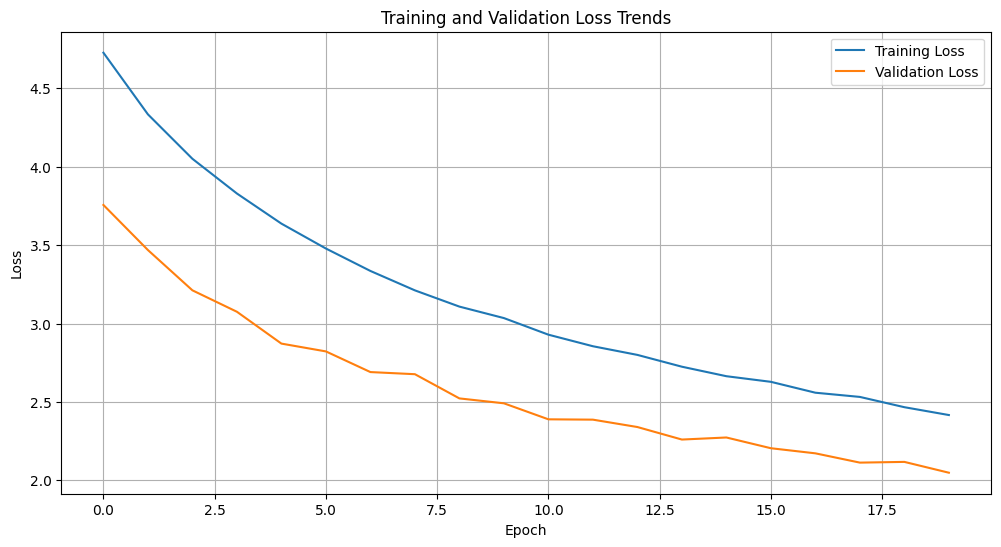

30939


In [12]:
# 모델 학습 
model = train_model(model, train_dataset, val_dataset, after_add_Trained_Tokenizer , 20, early_stopping_patience=5)

print(len(after_add_Trained_Tokenizer))

# 모델 저장
save_model(model, after_add_Trained_Tokenizer, "beomi/kcbert-base")

In [44]:
torch.cuda.is_available()

True

@ model : kcBert-base
- 기본 : 98 epoch, HITRATE : 0.079
- 표준편차를 조정 : 30 epoch, HITRATE : 0.093
- 기존 weights freeze : 20 epoch , HITRATE : 0.136295
- 레퍼런스 코드 따라한 기본: 188 epoch , HITRATE : 0.07938
- ( vocab추가 : 10000 ), vocab 정리, valid set 생성(과적합 탐지), (lr, optim 변경), 기존 weights freeze : 10 epoch HITRATE : 0.14977
- ( vocab추가 : 30000 ) , 기존 weights freeze, (dropout : 0.3) : 26 epoch HITRATE : 0.10933
- ( vocab추가 : 30000 ) , @@데이터 추가@@, 기존 weights freeze, (dropout : 0.3) : 100 epoch HITRATE : 0.1253
- ( vocab추가 : 10000 ) , @@데이터 추가@@, 기존 weights freeze, (dropout : 0.3) : 100 epoch HITRATE :


@ model : KcBert-v2023 
- ( vocab추가 : 30000 총 79871 ) , 기존 weights freeze, (dropout : 0.3) : _epoch HITRATE : 

## for test

토큰학습

토큰 추가 후 최종 토크나이저

In [35]:
from transformers import BertTokenizerFast
text = '  공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. '
tokenizer =BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/",do_lower_case=False)
# 텍스트 토큰화
tokenized_output = tokenizer.encode(text, add_special_tokens=False)
print(tokenized_output)
print("tokenizer len:",len(tokenizer))
# 토큰화 결과 출력
for output in tokenized_output:
    decoded_output = tokenizer.decode(output)
    print("Decoded Text:", decoded_output)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[34904, 31027, 33480, 30994, 2255, 31029, 17238, 14639, 11144, 15328, 10302, 17572, 13248, 8008, 17]
tokenizer len: 36196
Decoded Text: 공정변수를
Decoded Text: 진공
Decoded Text: 성형의
Decoded Text: 사출성형해석
Decoded Text: 에
Decoded Text: 요인
Decoded Text: 배치
Decoded Text: ##로써
Decoded Text: 공급
Decoded Text: ##부에
Decoded Text: 중요한
Decoded Text: 역할을
Decoded Text: 제공
Decoded Text: ##한다
Decoded Text: .


In [14]:
from transformers import BertTokenizer

text = ["공정변수가 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다."]
tokenizer = BertTokenizer.from_pretrained('/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/bertwordpiece', do_basic_tokenize=False)
# 텍스트 토큰화
tokenized_output = tokenizer.encode(str(text), add_special_tokens=True)
print(tokenized_output)

# 토큰화 결과 출력
for output in tokenized_output:
    decoded_output = tokenizer.decode(output, skip_special_tokens=True)
    print("Decoded Text:", decoded_output)

[2, 1, 1, 1785, 4208, 4093, 4572, 4032, 27667, 1, 1, 10302, 17572, 1, 3]
Decoded Text: [ C L S ]
Decoded Text: [ U N K ]
Decoded Text: [ U N K ]
Decoded Text: 사
Decoded Text: # # 출
Decoded Text: # # 성
Decoded Text: # # 형
Decoded Text: # # 해
Decoded Text: # # 석 에
Decoded Text: [ U N K ]
Decoded Text: [ U N K ]
Decoded Text: 중 요 한
Decoded Text: 역 할 을
Decoded Text: [ U N K ]
Decoded Text: [ S E P ]


In [20]:
from transformers import BertTokenizerFast
text = '  공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. '
tokenizer =BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/",do_lower_case=False)
# 텍스트 토큰화
tokenized_output = tokenizer.encode(text, add_special_tokens=False)
print(tokenized_output)
print("tokenizer len:",len(tokenizer))
# 토큰화 결과 출력
for output in tokenized_output:
    decoded_output = tokenizer.decode(output)
    print("Decoded Text:", decoded_output)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[34904, 31027, 33480, 30994, 2255, 31029, 17238, 14639, 11144, 15328, 10302, 17572, 13248, 8008, 17]
tokenizer len: 36196
Decoded Text: 공정변수를
Decoded Text: 진공
Decoded Text: 성형의
Decoded Text: 사출성형해석
Decoded Text: 에
Decoded Text: 요인
Decoded Text: 배치
Decoded Text: ##로써
Decoded Text: 공급
Decoded Text: ##부에
Decoded Text: 중요한
Decoded Text: 역할을
Decoded Text: 제공
Decoded Text: ##한다
Decoded Text: .


In [10]:
# 새 토큰의 ID 확인
token_id = tokenizer.convert_tokens_to_ids("공정변수")
print("Token ID for '공정변수':", token_id)

# 직접 인코딩과 디코딩을 통한 검증
encoded_text = tokenizer.encode("공정변수", add_special_tokens=False)
decoded_text = tokenizer.decode(encoded_text)
print("Encoded and Decoded Text:", decoded_text)

Token ID for '공정변수': 31021
Encoded and Decoded Text: 공정변수


In [13]:
test_str = ' [CLS] 공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. [SEP]'
print('테스트 문장: ',test_str)

encoded_str = tokenizer.encode(test_str,add_special_tokens=False)
print('문장 인코딩: ',encoded_str)

decoded_str = tokenizer.decode(encoded_str)
print('문장 디코딩: ',decoded_str)

테스트 문장:   [CLS] 공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. [SEP]
문장 인코딩:  [2, 34904, 31027, 33480, 30994, 2255, 31029, 17238, 14639, 11144, 15328, 10302, 17572, 13248, 8008, 17, 3]
문장 디코딩:  [CLS] 공정변수를 진공 성형의 사출성형해석 에 요인 배치로써 공급부에 중요한 역할을 제공한다. [SEP]


In [5]:
tokenizer = BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/")
def chunk_text(text, chunk_size=5100):
    token_ids = tokenizer.encode(text, add_special_tokens=False)  # 특수 토큰을 제외하고 인코딩
    return [token_ids[i:i + chunk_size] for i in range(0, len(token_ids), chunk_size)]

# 예시 텍스트
text = "공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다."

# 텍스트를 청크로 나누기
chunks = chunk_text(text)

# 각 청크를 별도로 처리
for chunk in chunks:
    inputs = tokenizer.decode(chunk, skip_special_tokens=True)  # 토큰 ID를 다시 텍스트로 디코드
    print(inputs)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


사출성형해석 에 중요한 역할을 제공한다.


In [26]:
from transformers import BertTokenizerFast
text = '  공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. '
tokenizer =BertTokenizerFast.from_pretrained("beomi/KcBERT-v2023",do_lower_case=False)
# 텍스트 토큰화
tokenized_output = tokenizer.encode(text, add_special_tokens=False)
print(tokenized_output)
print("tokenizer len:",len(tokenizer))
# 토큰화 결과 출력
for output in tokenized_output:
    decoded_output = tokenizer.decode(output)
    print("Decoded Text:", decoded_output)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


[225, 1856, 1221, 3132, 581, 621, 20893, 342, 364, 924, 20893, 322, 10240, 1271, 13342, 11746, 1486, 4736, 11378, 4289, 13756, 7260, 733, 18, 225]
tokenizer len: 50265
Decoded Text:  
Decoded Text:  공정
Decoded Text: 변
Decoded Text: 수를
Decoded Text:  진
Decoded Text: 공
Decoded Text: 성형
Decoded Text: 의
Decoded Text:  사
Decoded Text: 출
Decoded Text: 성형
Decoded Text: 해
Decoded Text: 석에
Decoded Text:  요
Decoded Text: 인배
Decoded Text: 치로
Decoded Text: 써
Decoded Text:  공급
Decoded Text: 부에
Decoded Text:  중요한
Decoded Text:  역할을
Decoded Text:  제공
Decoded Text: 한다
Decoded Text: .
Decoded Text:  
